# Identifying the relationship between the Fair Market Rates and Consumer Price Index of a Metro area

In [62]:
import fetchData
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Data Preparation

In [2]:
API_file = 'API_Config.ini'
BLS_area_codes = 'Data/BLS/cu.area.txt'
analysis_start_year = 2014
analysis_end_year = 2024

### Loading the list of metro areas whose CPI data is present in the Bureau of Labour Statistics database

In [3]:
#fetching series id's for every metro area available in the Bureau of Labour Statistic's database
series_id = fetchData.get_bls_series_id(metro_code_file=BLS_area_codes)
series_id.head()

,area_code,area_name,area_state
1,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH
2,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA
3,CUURS12BSA0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD
5,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI
6,CUURS23BSA0,Detroit-Warren-Dearborn,MI


In [4]:
series_id.isna().sum()

area_code     0
area_name     0
area_state    0
dtype: int64

The dataset has no missing values

#### Cleaning the CPI Data

In [5]:
series_id['area_state'].unique()

<StringArray>
[      'MA-NH',    'NY-NJ-PA', 'PA-NJ-DE-MD',    'IL-IN-WI',          'MI',
       'MN-WI',       'MO-IL', 'DC-VA-MD-WV',          'FL',          'GA',
          'MD',          'TX',          'AZ',          'CO',          'CA',
          'WA',      'Hawaii',      'Alaska']
Length: 18, dtype: string

On further inspection, there are some rows for which the state names [Hawaii and Alaska] are not abbreviated. This can later cause an issue while merging this dataset with the HUD dataset.

In [6]:
series_id.loc[series_id['area_state'] == 'Hawaii','area_state'] = 'HI'
series_id.loc[series_id['area_state'] == 'Alaska','area_state'] = 'AK'
series_id['area_state'].unique()

<StringArray>
[      'MA-NH',    'NY-NJ-PA', 'PA-NJ-DE-MD',    'IL-IN-WI',          'MI',
       'MN-WI',       'MO-IL', 'DC-VA-MD-WV',          'FL',          'GA',
          'MD',          'TX',          'AZ',          'CO',          'CA',
          'WA',          'HI',          'AK']
Length: 18, dtype: string

After processing, the dataframe has no missing / incorrect values.

### Loading the list of metro areas whose FMR data is available in the HUD database

In [7]:
hud_metro_data = fetchData.get_metro_codes_hud(api_config=API_file)
hud_metro_data.head()

,cbsa_code,area_name,area_state
0,METRO10180M10180,Abilene,TX
1,METRO29180N22001,Acadia Parish,LA
2,METRO10380M10380,Aguadilla-Isabela,PR
3,METRO10420M10420,Akron,OH
4,METRO10500M10500,Albany,GA


In [8]:
hud_metro_data.isna().sum()

cbsa_code     0
area_name     0
area_state    0
dtype: int64

This dataset has no missing values.

#### Cleaning the FMR data

In [9]:
hud_metro_data['area_state'].unique()

<StringArray>
[          'TX',           'LA',           'PR',           'OH',
           'GA',           'OR',           'NY',           'NM',
           'KY',           'PA',           'IA',           'AK',
           'IN',           'SC',           'MI',           'AL',
           'WI',           'NC',           'NJ',        'GA-SC',
           'FL',           'CA',           'MD',           'ME',
           'MA',           'MO',           'WA',           'MS',
           'MT',           'ND',           'VA',           'IL',
           'ID',           'WV',        'MA-NH',           'CO',
           'UT',           'CT',           'VT',           'TN',
        'MO-IL',           'NV',           'WY',        'NC-SC',
        'TN-GA',     'OH-KY-IN',        'TN-KY',        'GA-AL',
           'OK',        'MD-WV',           'SD',        'IA-IL',
           'DE',        'MN-WI',        'IN-KY',        'ND-MN',
           'AR',           'MN',           'AZ',        'AR-OK',
           

On further inspection, there is a row for which the state name [TX-Texarkana] is not correct. This can later cause an issue while merging this dataset with the BLS dataset.

In [10]:
hud_metro_data.loc[hud_metro_data['area_state'] == 'TX-Texarkana', 'area_state'] = 'TX'

After processing, the dataframe has no missing / incorrect values.

### Merging the two datasets to get the metro areas for which both the CPI and FMR data is available.

In [11]:
merge_data = pd.merge(series_id, hud_metro_data, on='area_name', how='left', suffixes=('_BLS', '_HUD'))
merge_data.isna().sum()

area_code          0
area_name          0
area_state_BLS     0
cbsa_code         12
area_state_HUD    12
dtype: int64

There are 12 rows from the BLS dataset that have no corresponding metro area in the HUD dataset. Ideally that should not be the case, HUD's database is quite extensive.

In [12]:
merge_data[merge_data['cbsa_code'].isna()]

,area_code,area_name,area_state_BLS,cbsa_code,area_state_HUD
0,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH,<NA>,<NA>
1,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA,<NA>,<NA>
3,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI,<NA>,<NA>
4,CUURS23BSA0,Detroit-Warren-Dearborn,MI,<NA>,<NA>
5,CUURS24ASA0,Minneapolis-St.Paul-Bloomington,MN-WI,<NA>,<NA>
8,CUURS35BSA0,Miami-Fort Lauderdale-West Palm Beach,FL,<NA>,<NA>
12,CUURS37ASA0,Dallas-Fort Worth-Arlington,TX,<NA>,<NA>
16,CUURS49ASA0,Los Angeles-Long Beach-Anaheim,CA,<NA>,<NA>
17,CUURS49BSA0,San Francisco-Oakland-Hayward,CA,<NA>,<NA>
19,CUURS49DSA0,Seattle-Tacoma-Bellevue,WA,<NA>,<NA>


In [13]:
hud_metro_data[hud_metro_data['area_name'].str.contains('Boston')]

,cbsa_code,area_name,area_state
61,METRO14460MM1120,Boston-Cambridge-Quincy,MA-NH


On further investigation, it is observed that the issue is arising due to some slight difference in the names. In this case, either the data from HUD or BLS is not correctly named. The names should not be different as they both are based on 'cbsa' codes. To resolve this, we can try to find the best possible match and proceed accordingly. If no match is found, then that row will be dropped.

In [14]:
unmatched_indices = merge_data[merge_data['cbsa_code'].isna()].index
unmatched_areas_metro = list(merge_data['area_name'][merge_data['cbsa_code'].isna()].apply(lambda x: x.split('-')[0]))
unmatched_dict = dict(zip(unmatched_indices, unmatched_areas_metro))
for i in unmatched_indices:
    hud_area = hud_metro_data[hud_metro_data['area_name'].str.contains(unmatched_dict[i])]
    if len(hud_area) > 1:
        hud_area = hud_area[hud_area['area_state'] == merge_data['area_state_BLS'].loc[i]]
    if len(hud_area) == 1:
        merge_data.loc[i, 'cbsa_code'] = hud_area['cbsa_code'][hud_area['area_name'].str.contains(unmatched_dict[i])].values
merge_data[merge_data['cbsa_code'].isna()]

,area_code,area_name,area_state_BLS,cbsa_code,area_state_HUD
22,CUURS49GSA0,Urban,AK,<NA>,<NA>


In [15]:
merge_data = merge_data.dropna(subset=['cbsa_code']).drop(columns=['area_state_HUD']).rename(columns={'area_state_BLS': 'area_state'})

One row (Urban Alaska) is dropped as there is no corresponding metro area in the HUD dataset.

### Selecting a metro area for analysis

In [16]:
print('following is the list of available metro_areas:')
merge_data.head(100)

following is the list of available metro_areas:


,area_code,area_name,area_state,cbsa_code
0,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH,METRO14460MM1120
1,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA,METRO35620MM5600
2,CUURS12BSA0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD,METRO37980M37980
3,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI,METRO16980M16980
4,CUURS23BSA0,Detroit-Warren-Dearborn,MI,METRO19820M19820
5,CUURS24ASA0,Minneapolis-St.Paul-Bloomington,MN-WI,METRO33460M33460
6,CUURS24BSA0,St. Louis,MO-IL,METRO41180M41180
7,CUURS35ASA0,Washington-Arlington-Alexandria,DC-VA-MD-WV,METRO47900M47900
8,CUURS35BSA0,Miami-Fort Lauderdale-West Palm Beach,FL,METRO33100MM5000
9,CUURS35CSA0,Atlanta-Sandy Springs-Roswell,GA,METRO12060M12060


In [17]:
index = fetchData.select_area(merge_data)

San Diego-Carlsbad has been selected


### Loading State data for the selected metro area

In [25]:
state_code = merge_data['area_state'].iloc[int(index)].split('-')[0]
state_code

'CA'

In [26]:
state_data = fetchData.fetch_state_fmr_data(api_config=API_file, start_year=analysis_start_year, end_year=analysis_end_year, state_code=state_code)
state_data.head()

,code,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,year
0,METRO12540M12540,623.0,650.0,844.0,1222.0,1470.0,2017-10-01
1,METRO17020M17020,656.0,729.0,923.0,1344.0,1614.0,2017-10-01
2,METRO20940M20940,522.0,626.0,822.0,1123.0,1434.0,2017-10-01
3,METRO23420M23420,670.0,709.0,887.0,1258.0,1470.0,2017-10-01
4,METRO25260M25260,619.0,623.0,803.0,1133.0,1296.0,2017-10-01


### Loading CPI data for the selected metro area

In [19]:
cpi_id = merge_data['area_code'].iloc[int(index)]
cpi_id

'CUURS49ESA0'

In [21]:
cpi_data = fetchData.fetch_metro_cpi_bls(api_config=API_file, area_code=cpi_id, start_year=analysis_start_year, end_year=analysis_end_year)
cpi_data.head()

Month,01,03,05,07,09,11
year,,,,,,
2017,<NA>,<NA>,<NA>,<NA>,<NA>,285.960999
2018,288.330994,290.809998,289.243011,295.184998,295.882996,293.858002
2019,295.760986,297.226013,300.303009,299.333008,301.03299,301.519989
2020,302.563995,302.588989,301.316986,305.610992,304.442993,306.334015
2021,307.687988,315.035004,317.140991,323.906006,324.138,326.421997


### Loading FMR data for the selected metro area

In [28]:
cbsa_code = merge_data['cbsa_code'].iloc[int(index)]
cbsa_code

'METRO41740M41740'

In [ ]:
# cbsa_data = fetchData.fetch_metro_fmr_data(api_config=API_file, start_year=analysis_start_year, end_year=analysis_end_year, metro_code=cbsa_code)
# cbsa_data.head()

In [31]:
cbsa_data = state_data[state_data['code'] == cbsa_code].reset_index(drop=True)

In [32]:
cbsa_data

,code,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,year
0,METRO41740M41740,1212.0,1342.0,1741.0,2507.0,3068.0,2017-10-01
1,METRO41740M41740,1257.0,1400.0,1816.0,2612.0,3198.0,2018-10-01
2,METRO41740M41740,1333.0,1490.0,1938.0,2776.0,3404.0,2019-10-01
3,METRO41740M41740,1404.0,1566.0,2037.0,2894.0,3576.0,2020-10-01
4,METRO41740M41740,1478.0,1642.0,2124.0,2987.0,3677.0,2021-10-01
5,METRO41740M41740,1573.0,1739.0,2232.0,3099.0,3795.0,2022-10-01
6,METRO41740M41740,1714.0,1885.0,2399.0,3279.0,3988.0,2023-10-01
7,METRO41740M41740,2062.0,2248.0,2833.0,3819.0,4638.0,2024-10-01


## 

## Identifying Lag in CPI and FMR

In [39]:
years = cpi_data.index
def date_parser(x: str, yr: str):
    x = yr+' '+x
    return datetime.strptime(x, '%Y %m')
years = cpi_data.index
for year in range(len(years)):
    y = pd.DataFrame(cpi_data.loc[years[year]])
    y.reset_index(inplace=True)
    y['Date'] = y['Month'].apply(lambda x: date_parser(x, years[year]))
    y = y.drop(columns=['Month']).set_index('Date').rename(columns={years[year]: 'CPI'})
    if year ==0:
        cpi_data_t = y.copy()
    else:
        cpi_data_t = pd.concat([cpi_data_t, y], axis=0)
cpi_data_t

,CPI
Date,
2017-01-01,<NA>
2017-03-01,<NA>
2017-05-01,<NA>
2017-07-01,<NA>
2017-09-01,<NA>
2017-11-01,285.960999
2018-01-01,288.330994
2018-03-01,290.809998
2018-05-01,289.243011


In [50]:
fmr_implementation_period = pd.date_range("2017-10-01", periods=8, freq="YS-OCT")
fmr_implementation_period

DatetimeIndex(['2017-10-01', '2018-10-01', '2019-10-01', '2020-10-01',
               '2021-10-01', '2022-10-01', '2023-10-01', '2024-10-01'],
              dtype='datetime64[ns]', freq='YS-OCT')

In [53]:
cpi_data_smooth = cpi_data_t.groupby(pd.Grouper(freq='YS-OCT')).mean()

In [81]:
combined = pd.merge(cbsa_data.set_index('year'), cpi_data_smooth, how='inner' ,left_index=True, right_index=True)
combined.drop(columns=['code'], inplace=True)
all_cols = combined.columns

In [82]:
combined_normalized = (combined-combined.mean()) / combined.std()
combined_normalized

,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,CPI
2017-10-01,-1.19146,-1.247352,-1.293424,-1.373338,-1.40925,-1.111722
2018-10-01,-0.939066,-0.944103,-0.970068,-0.985851,-1.012217,-0.880651
2019-10-01,-0.512801,-0.473545,-0.444076,-0.380633,-0.383072,-0.713088
2020-10-01,-0.114579,-0.076185,-0.017246,0.054828,0.142234,-0.294877
2021-10-01,0.300469,0.321175,0.357847,0.398031,0.450699,0.510321
2022-10-01,0.833301,0.828331,0.82348,0.81135,0.811083,1.117407
2023-10-01,1.624135,1.591681,1.543486,1.475613,1.400525,1.372609


<Axes: >

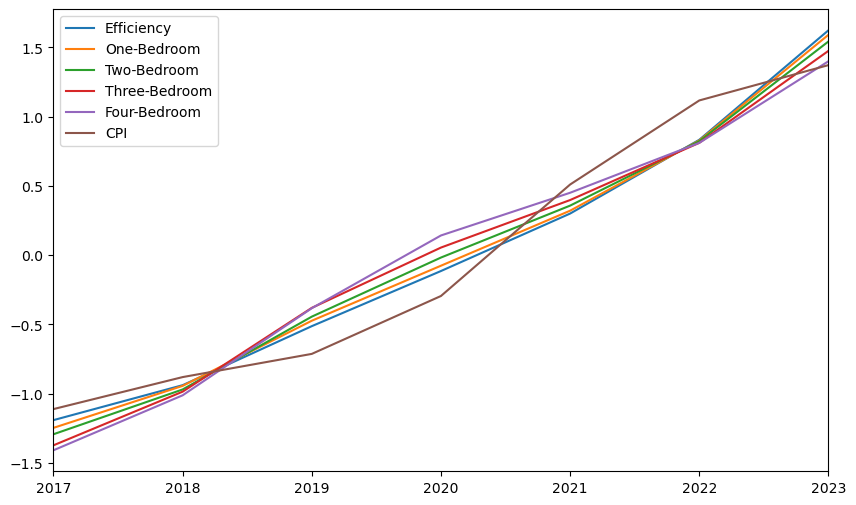

In [83]:
combined_normalized.plot(kind='line', figsize=(10, 6))

<Axes: >

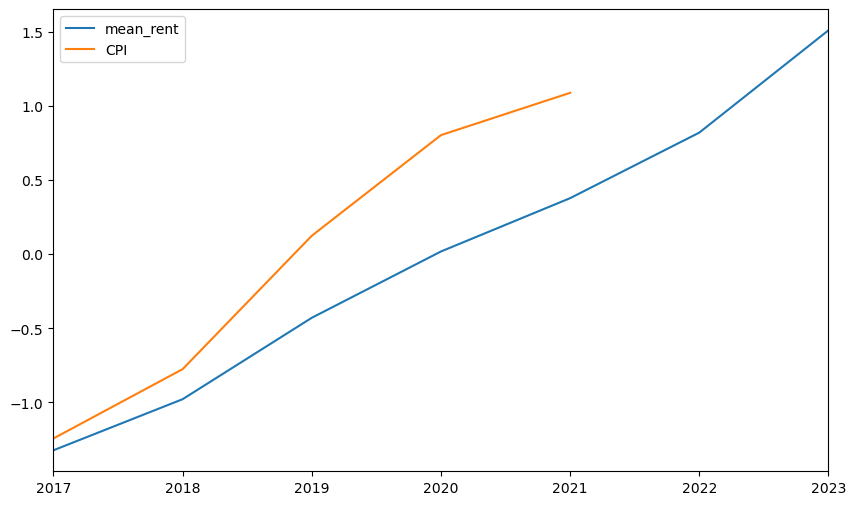

In [95]:
combined_1_yr_shift = combined.copy()
combined_1_yr_shift['CPI'] = combined_1_yr_shift['CPI'].shift(-2)
combined_1_yr_shift['mean_rent'] = combined_1_yr_shift[['Efficiency', 'One-Bedroom', 'Two-Bedroom', 'Three-Bedroom', 'Four-Bedroom']].mean(axis=1)
combined_1_yr_shift = (combined_1_yr_shift - combined_1_yr_shift.mean())/combined_1_yr_shift.std()
combined_1_yr_shift[['mean_rent','CPI']].plot(kind='line', figsize=(10, 6))